## Capstone Project

#### Submitted by : Group 6 - Rajesh S, Vidhya K, Sathiyakailash S, Yagnaraman M, Laxmanan
#### Context : 
Now-a-days, even a small successful supermarket has the capacity to expend beyond their usual territory and have multiple shops, in multiple locations. The project Group #6 aims at achieving  an accurate prediction mechanism to serve the supermarket owner(s) or managers to manage their sales and purchases.
For this the team has considered the Kaggle problem of Corporación Favorita, a large Ecuadorian-based grocery retailer. We will try to achieve the problem statement provided in the competition, to predict the sales of each items (Date, Store, Item ID and the Unit of Sales).

In addition to the problem description provided in the Kaggle competition, given the time, the team will also try to implement models for prediction involving time-period and shelf-space planning.  


### Index
1. [Time Series Analysis - ARIMA](#arima1)
2. [Time Series Analysis on Store #44](#store44)
3. [ARIMA model for Time Series](#arima2)
4. [Auto Arima for Time Series](#arima3)
5. [Sulekha-Holtwinters implementation](#sulekhaholt)
6. [Prohphet and Time Series](#prophet)
7. [Prediction for Top 10 Items](#itempred)

In [1]:
# Import the libraries require for data processing, Pyspark and Time Series ARIMA
import pandas as pd
import numpy as np
import datetime

# For Spark
from pyspark.sql import  SparkSession
from pyspark import SparkContext
from pyspark.sql.types import *
from pyspark import SQLContext
import matplotlib.pyplot as plt

from pyspark.sql.functions import col, countDistinct
from pyspark.sql.functions import isnan, when, count, col
from pyspark.sql.functions import year, month, dayofmonth

# For Beautiful Plotting
import matplotlib as plot
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15, 6

# TIME SERIES
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.stattools import adfuller, acf, pacf,arma_order_select_ic
from fbprophet import Prophet

/usr/local/anaconda/python2/lib/python2.7/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


## <a id="arima1">1. Time Series Analysis - ARIMA</a>

In [2]:
# Create Spark Context and SQL Context
sc = SparkContext()
sqlContext = SQLContext(sc)

In [3]:
# Read the transaction data from hdfs storage
transaction_data = sqlContext.read.csv("/gl-capstone-data/Team6-C-Sep/Data/transactions_store44.csv",header = True,inferSchema = True)

In [4]:
# Read the store details data from hadoop
stores_data=sqlContext.read.csv("/gl-capstone-data/Team6-C-Sep/Data/stores.csv",header = True,inferSchema = True)

In [5]:
# Form the Sales data frame from transaction data and to EDA
sales_df =pd.merge(transaction_data.toPandas(),stores_data.toPandas(),how='left')
sales_df.describe()

,store_nbr,transactions,cluster
count,1089.0,1089.000000,1089.0
mean,44.0,4325.125803,5.0
std,0.0,749.300106,0.0
min,44.0,2333.000000,5.0
25%,44.0,3797.000000,5.0
50%,44.0,4133.000000,5.0
75%,44.0,4787.000000,5.0
max,44.0,8359.000000,5.0


In [6]:
sales_df.head()

,date,store_nbr,transactions,city,state,type,cluster
0,2013-01-02,44,4821,Quito,Pichincha,A,5
1,2013-01-03,44,3618,Quito,Pichincha,A,5
2,2013-01-04,44,4169,Quito,Pichincha,A,5
3,2013-01-05,44,4921,Quito,Pichincha,A,5
4,2013-01-06,44,4925,Quito,Pichincha,A,5


In [7]:
# The holiday data has events and holidays for Ecuador local/National and Regional stores.
holiday_data = sqlContext.read.csv("/gl-capstone-data/Team6-C-Sep/Data/holidays_events_2013_2015.csv",header = True,inferSchema = True)
holiday_data_df = holiday_data.toPandas()

In [8]:
holiday_data_df['date'] = pd.to_datetime(holiday_data_df['date'], format='%b %d, %Y')
sales_df['date'] = pd.to_datetime(sales_df['date'], format='%b %d, %Y')

In [9]:
# Isolating events that do not correspond to holidays
events=holiday_data_df.loc[holiday_data_df.type=='Event']
holiday_data_df=holiday_data_df.loc[holiday_data_df.type!='Event']

In [10]:
# Adjusting this variable to show all holidays
sales_df['year'],sales_df['week'],sales_df['day']=list(zip(*sales_df.date.apply(lambda x: x.isocalendar())))

# Creating a categorical variable showing weekends
sales_df['dayoff']=[x in [6,7] for x in sales_df.day]

# Adjuusting this variable to show all holidays
for (d,t,l,n) in zip(holiday_data_df.date,holiday_data_df.type,holiday_data_df.locale,holiday_data_df.locale_name):
  if t!='Work Day':
    if l=='National':
      sales_df.loc[sales_df.date==d,'dayoff']=True
    elif l=='Regional':
      sales_df.loc[(sales_df.date==d)&(sales_df.state==n),'dayoff']=True
    else:
      sales_df.loc[(sales_df.date==d)&(sales_df.city==n),'dayoff']=True
  else:
    sales_df.loc[(sales_df.date==d),'dayoff']=False

In [11]:
sales_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1089 entries, 0 to 1088
Data columns (total 11 columns):
date            1089 non-null datetime64[ns]
store_nbr       1089 non-null int64
transactions    1089 non-null int64
city            1089 non-null object
state           1089 non-null object
type            1089 non-null object
cluster         1089 non-null int64
year            1089 non-null int64
week            1089 non-null int64
day             1089 non-null int64
dayoff          1089 non-null bool
dtypes: bool(1), datetime64[ns](1), int64(6), object(3)
memory usage: 94.6+ KB


In [12]:
holiday_data_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 149 entries, 0 to 169
Data columns (total 6 columns):
date           149 non-null datetime64[ns]
type           149 non-null object
locale         149 non-null object
locale_name    149 non-null object
description    149 non-null object
transferred    149 non-null bool
dtypes: bool(1), datetime64[ns](1), object(4)
memory usage: 7.1+ KB


In [13]:
sales_df.head()

,date,store_nbr,transactions,city,state,type,cluster,year,week,day,dayoff
0,2013-01-02,44,4821,Quito,Pichincha,A,5,2013,1,3,False
1,2013-01-03,44,3618,Quito,Pichincha,A,5,2013,1,4,False
2,2013-01-04,44,4169,Quito,Pichincha,A,5,2013,1,5,False
3,2013-01-05,44,4921,Quito,Pichincha,A,5,2013,1,6,False
4,2013-01-06,44,4925,Quito,Pichincha,A,5,2013,1,7,True


In [14]:
sales_df.count()

date            1089
store_nbr       1089
transactions    1089
city            1089
state           1089
type            1089
cluster         1089
year            1089
week            1089
day             1089
dayoff          1089
dtype: int64

## <a id="store44">2. Time series analysis on Store #44 </a>

#### We will be doing the analysis only on Store #44 considering the volume of data in the original files provided in Kaggle.

In [15]:
# Load the training data for Store #44 which has already been segregated from the original Train data 
train_data = sqlContext.read.csv("/gl-capstone-data/Team6-C-Sep/Data/train_store44_with_items.csv",header = True,inferSchema = True)

In [16]:
# Total records should match 
ts=sales_df.loc[sales_df['store_nbr']==44,['date','transactions']].set_index('date')
ts.count()
ts=ts.transactions.astype('float')

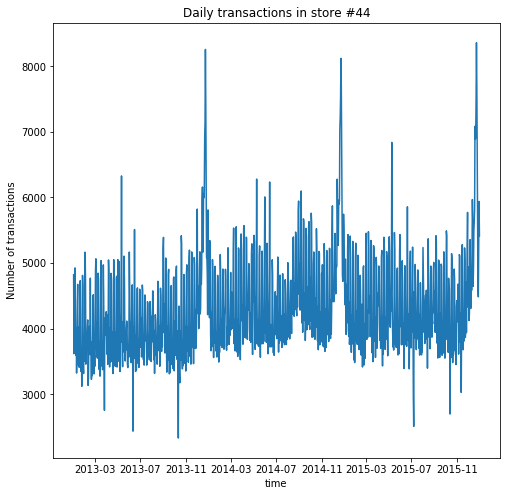

In [17]:
# Let us plot the daily transaction as time series and observe the trend
plt.figure(figsize=(8,8))
plt.title('Daily transactions in store #44')
plt.xlabel('time')
plt.ylabel('Number of transactions')
plt.plot(ts);

#### Observation:

There are several peaks just before every year end. We can attribute this to the seasonality. The sales will surge during Year and and christmas.

#### For finding the stationarity of the timeseries, we will apply Dicky Fuller Test. The Dickey Fuller (let us call it as DF) test will assume a null hypothesis of non Stationarity.

In [18]:
def dickey_fuller_test(timeseries):
    dickey_fuller_test = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dickey_fuller_test[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dickey_fuller_test[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

In [19]:
dickey_fuller_test(ts)

Test Statistic                   -4.013363
p-value                           0.001342
#Lags Used                       22.000000
Number of Observations Used    1066.000000
Critical Value (5%)              -2.864255
Critical Value (1%)              -3.436499
Critical Value (10%)             -2.568216
dtype: float64


#### The Time Series can be classified in to Stationary or Non Stationary. Time series are stationary if they do not have trend or seasonal effects. Summary statistics calculated on the time series are consistent over time, like the mean or the variance of the observations.
#### The Dickey-Fuller test has null-hypothesis that the time-series is non stationary. On our case the P value is less than 0.05. Hence we can reject the null hypothoesis and consider the time series as Stationary.

### <a id="arima2">3. ARIMA Model for Timeseries</a>

ARIMA stands for AutoRegressive Integrated Moving Average.The ARIMA models have three parameters, corresponging to its AR, I and MA components:

1. The number of autoregressive (AR) terms (p): AR terms are just lags of the dependent variable.
2. The number of differences (d): These are the number of non-seasonal differences.
3. The number of moving average (MA) terms (q): MA terms are lagged forecast errors in the prediction equation.

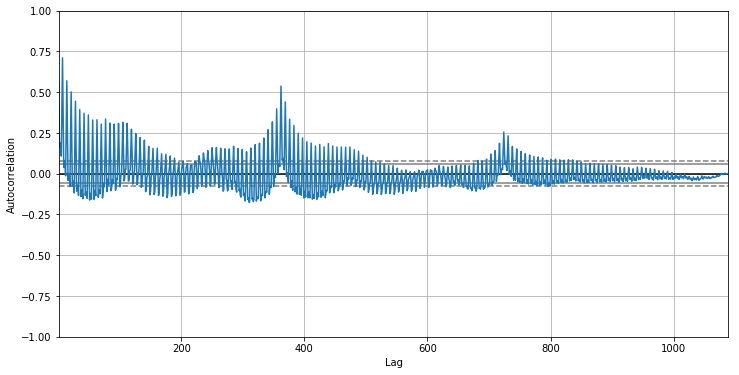

In [20]:
# Before that let us do an auto Correlation plot for the timeseries.
plt.figure(figsize=(12,6))
autocorrelation_plot(ts);

#### The above plot shows that the peaks are attained once every 365 days. That sums up the seasonality.

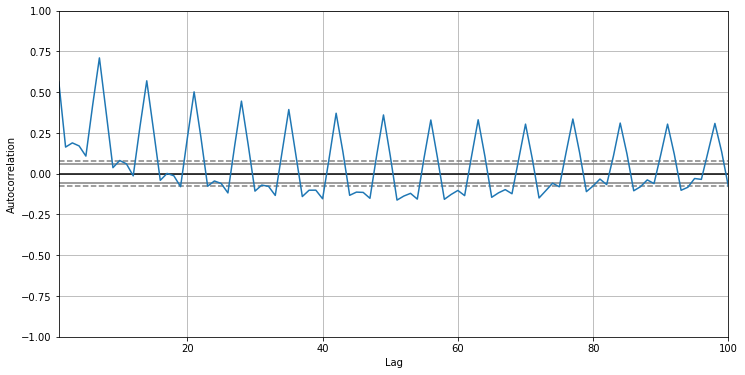

In [21]:
plt.figure(figsize=(12,6))
autocorrelation_plot(ts);
plt.xlim(xmax=100);

#### If we limit this to 100 days, there are total of 14 spikes. Roughly once every 7 days. That also answers the trend that the Ecudorians follow weekly purchases mode.

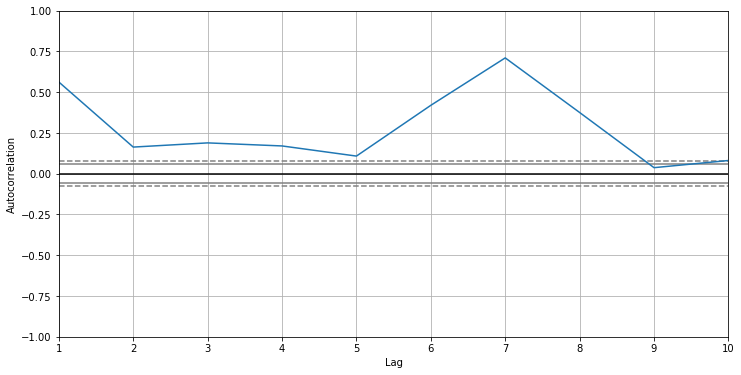

In [22]:
plt.figure(figsize=(12,6))
autocorrelation_plot(ts);
plt.xlim(xmax=10);

#### This is further confirmed by the 10 days plot. where there is a spike at 7th day.

#### In the below code, a graph is ploted between the log time series and the moving average of  days.

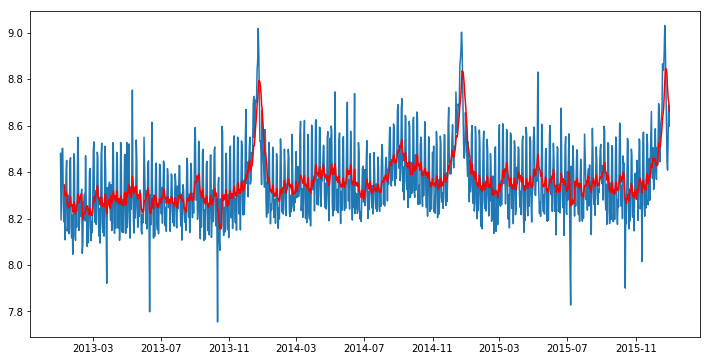

In [23]:
plt.figure(figsize=(12,6))
ts_log = np.log(ts)
moving_avg = ts_log.rolling(window = 8, center=False).mean()
plt.plot(ts_log)
plt.plot(moving_avg, color='red')
plt.show()

In [24]:
# The moving average difference between the original time series and the moving average of 8 days is calculated.
ts_log_moving_avg_diff = ts_log - moving_avg
ts_log_moving_avg_diff.head(10)

date
2013-01-02         NaN
2013-01-03         NaN
2013-01-04         NaN
2013-01-05         NaN
2013-01-06         NaN
2013-01-07         NaN
2013-01-08         NaN
2013-01-09   -0.049045
2013-01-10   -0.189456
2013-01-11   -0.044809
Name: transactions, dtype: float64

In [25]:
# The DF Test is applied on the moving average time series after dropping the NAN data to check the stationality
ts_log_moving_avg_diff.dropna(inplace=True)
dickey_fuller_test(ts_log_moving_avg_diff)

Test Statistic                -7.937679e+00
p-value                        3.379080e-12
#Lags Used                     2.200000e+01
Number of Observations Used    1.059000e+03
Critical Value (5%)           -2.864273e+00
Critical Value (1%)           -3.436540e+00
Critical Value (10%)          -2.568225e+00
dtype: float64


#### This looks like a much better series. The rolling values appear to be varying slightly but there is no specific trend. Also, the test statistic is smaller than the 5% critical values so we can say with 95% confidence that this is a stationary series.

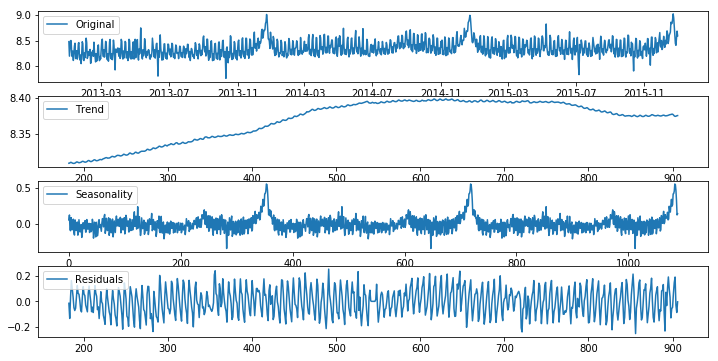

In [26]:
#### Let us plot the timeseries with decomposition data. I.e. Trend, Seasonal and Residual. The frequency is for 365 days.
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log.values, freq=365)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.figure(figsize=(12,6))
plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.show()

#### It is observed that over a year data, there is a definite trend in the sales. The seasonality is also well explained here as per our expection.

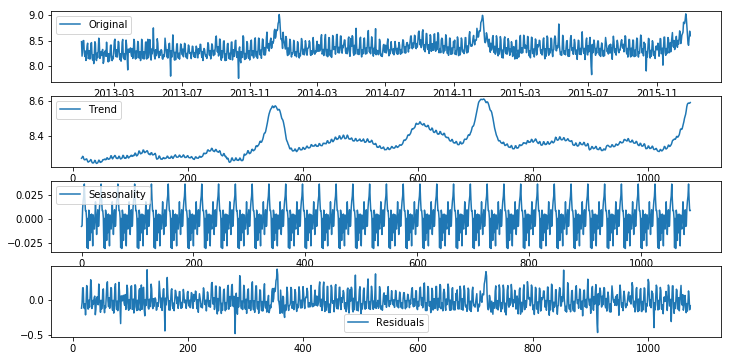

In [27]:
#### Let us plot the timeseries with decomposition data. I.e. Trend, Seasonal and Residual. The frequency is for 30 days.
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log.values, freq=30)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.figure(figsize=(12,6))
plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')

#### Over 30 days, if we observe correctly, there are six spikes approx between 200 days, so that also confirms our analysis.

In [28]:
### Applying ARIMA with the pdq values 5,0,5 and check the residuals
pdq=(5,0,5)
model = ARIMA(ts_log, order = pdq, freq='W')  
results_AR = model.fit(disp=False,method='css',maxiter=100) 
residuals = pd.DataFrame(results_AR.resid)
residuals.head()

,0
date,
2013-01-07,-0.381552
2013-01-08,-0.357352
2013-01-09,0.117899
2013-01-10,0.026263
2013-01-11,0.055091


,count,mean,std,min,25%,50%,75%,max
0,1084.0,-0.000005,0.08955,-0.477191,-0.047955,0.003344,0.047386,0.408671


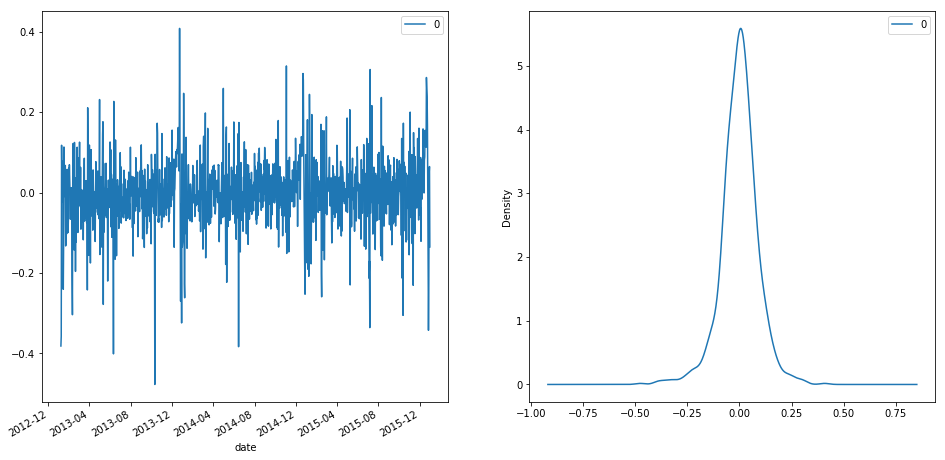

In [29]:
fig,axes = plt.subplots(nrows=1, ncols=2,figsize=(16,8))
residuals.plot(ax=axes[0])
residuals.plot(kind='kde',ax=axes[1]);
residuals.describe().T

In [30]:
results_AR.fittedvalues.head()

date
2013-01-07    8.642820
2013-01-08    8.544095
2013-01-09    8.177649
2013-01-10    8.082361
2013-01-11    8.206693
dtype: float64

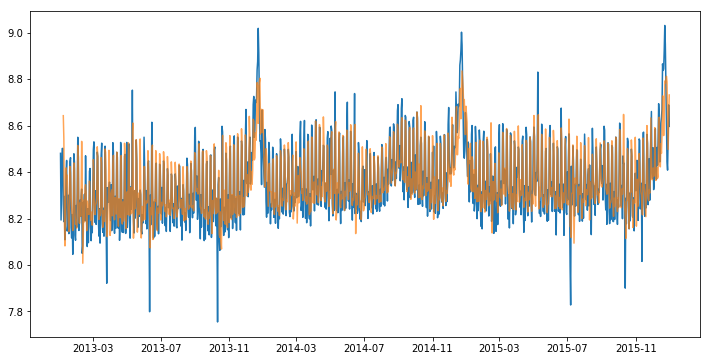

In [31]:
plt.figure(figsize=(12,6))
plt.subplot
plt.plot(ts_log);
plt.plot(results_AR.fittedvalues,alpha=.7);

#### Observation:
The model does fit well. But we can see that some part of the outliers are fitted.

In [32]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [33]:
#### Here, we will take the last 1 month data as test data from the entire ts_log and do the prediction.
forecast_len=30
size = int(len(ts)-forecast_len)
train, test = ts[0:size], ts[size:len(ts_log)]
history = [x for x in train]
predictions = list()
pdq=(5,0,5)

import warnings
warnings.filterwarnings("ignore")
from math import sqrt
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

print('Starting the ARIMA predictions...')
print('\n')
for t in range(len(test)):
    model = ARIMA(history, order = pdq, freq='D');
    model_fit = model.fit(disp=0);
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(float(yhat))
    obs = test[t]
    history.append(obs)
print('Predictions finished.\n')
rmse = sqrt(mean_squared_error(test, predictions))
print('The RMSE Value is : %f' % rmse) 
mape =  mean_absolute_percentage_error(test, predictions)
print('The MAPE is : %f' % mape)    

predictions_series = pd.Series(predictions, index = test.index)

Starting the ARIMA predictions...


Predictions finished.

The RMSE Value is : 827.007238
The MAPE is : 11.373812


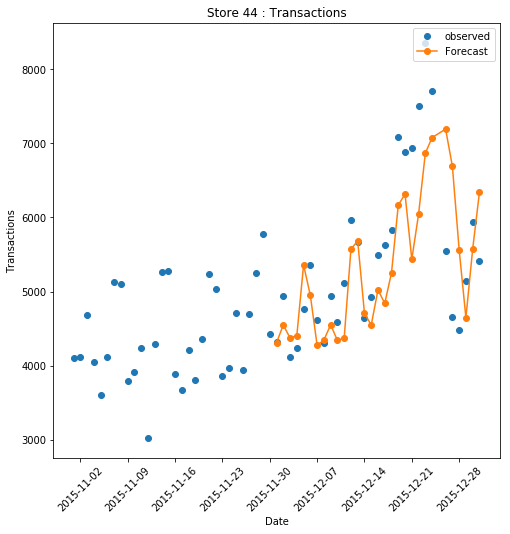

In [34]:
plt.figure(figsize=(8,8))
plt.title('Store 44 : Transactions')
plt.xlabel('Date')
plt.xticks(rotation=45)
plt.ylabel('Transactions')
plt.plot(ts[-2*forecast_len:], 'o', label='observed');
plt.plot(predictions_series, '-o',label='Forecast');
plt.legend(loc='upper right');

In [35]:
import numpy
def difference(dataset, interval=1):
	diff = list()
	for i in range(interval, len(dataset)):
		value = dataset[i] - dataset[i - interval]
		diff.append(value)
	return numpy.array(diff)

In [36]:
# invert differenced value
def inverse_difference(history, yhat, interval=1):
	return (yhat + history[-interval])/2

In [37]:
X = train.values

days_in_year = 365
differenced = difference(X, days_in_year)

start_index = len(differenced)
end_index = len(differenced) + 6
forecast = model_fit.predict(start=start_index, end=end_index)

In [38]:
# invert the differenced forecast to something usable
history = [x for x in X]

day = 1
for yhat in forecast:
	inverted = inverse_difference(history, yhat, days_in_year)
	print('Day %d: %f' % (day, inverted))
	history.append(inverted)
	day += 1

Day 1: 5345.906780
Day 2: 5526.381937
Day 3: 4601.921604
Day 4: 4380.282027
Day 5: 4554.397614
Day 6: 4291.867349
Day 7: 4593.693435


#### Calculating the monthly Sales forecast for the month.

In [39]:
X = train.values

days_in_year = 30
differenced = difference(X, days_in_year)

start_index = len(differenced)
end_index = len(differenced) + days_in_year
forecast = model_fit.predict(start=start_index, end=end_index)

In [40]:
# invert the differenced forecast to something usable
history_month = [x for x in X]
jan_arima_predict = []
month_sum = 0
day = 1
for yhat in forecast:
    inverted = inverse_difference(history_month, yhat, days_in_year)
    print('Day %d: %f' % (day, inverted))
    history_month.append(inverted)
    jan_arima_predict.append(inverted)
    month_sum = month_sum + inverted
    day += 1

Day 1: 4275.846686
Day 2: 3779.426693
Day 3: 4279.824438
Day 4: 4253.246720
Day 5: 3733.271777
Day 6: 4111.491305
Day 7: 4945.054650
Day 8: 4913.937949
Day 9: 4120.187919
Day 10: 4002.797880
Day 11: 4126.886332
Day 12: 3417.123604
Day 13: 4004.607801
Day 14: 5183.284240
Day 15: 5052.744919
Day 16: 4099.571058
Day 17: 3876.243237
Day 18: 4034.468279
Day 19: 3749.725943
Day 20: 4296.591370
Day 21: 5292.892955
Day 22: 4994.888057
Day 23: 3953.353420
Day 24: 3945.207356
Day 25: 4428.965761
Day 26: 4034.256933
Day 27: 4498.054465
Day 28: 5393.150056
Day 29: 5356.574263
Day 30: 4457.770241
Day 31: 4314.079116


In [41]:
print("Sum of Predicted Monthly Sales : ", month_sum)

('Sum of Predicted Monthly Sales : ', 134925.5254267519)


#### Let us form the JAN 2016 data for comparing the Predicted Vs Actuals

In [42]:
full_transaction_data = sqlContext.read.csv("/gl-capstone-data/Team6-C-Sep/Data/transactions.csv",header = True,inferSchema = True)
full_transaction_data.head()

Row(date=datetime.datetime(2013, 1, 1, 0, 0), store_nbr=25, transactions=770)

In [43]:
jan_2016_data =  full_transaction_data.filter(col('store_nbr') == 44).filter(year(col('date')) == 2016).filter(month(col('date')) == 1)
jan_2016_data_pd = jan_2016_data.toPandas()

In [44]:
jan_2016_data_pd = jan_2016_data_pd.drop(['store_nbr'], axis=1)
jan_2016_data_pd.set_index('date')
jan_2016_data_pd.head()

,date,transactions
0,2016-01-02,4539
1,2016-01-05,4113
2,2016-01-06,4661
3,2016-01-07,3866
4,2016-01-08,4301


In [45]:
jan_2016_data_pd['date'] = pd.to_datetime(jan_2016_data_pd['date'], format='%b %d, %Y')
jan_2016_data_pd.index = pd.to_datetime(jan_2016_data_pd['date'])
jan_2016_data_pd.columns = ['date', 'actuals']
jan_2016_data_pd.index

DatetimeIndex(['2016-01-02', '2016-01-05', '2016-01-06', '2016-01-07',
               '2016-01-08', '2016-01-09', '2016-01-10', '2016-01-11',
               '2016-01-12', '2016-01-13', '2016-01-14', '2016-01-15',
               '2016-01-16', '2016-01-17', '2016-01-18', '2016-01-19',
               '2016-01-20', '2016-01-21', '2016-01-22', '2016-01-23',
               '2016-01-24', '2016-01-25', '2016-01-26', '2016-01-27',
               '2016-01-28', '2016-01-29', '2016-01-30', '2016-01-31'],
              dtype='datetime64[ns]', name=u'date', freq=None)

#### Create a dataframe out of the predicted values

In [46]:
index = pd.date_range('2016-01-01', periods=31)
future_forecast_arima = pd.DataFrame(jan_arima_predict,index = index,columns=['Prediction_Arima'])
future_forecast_arima = future_forecast_arima.astype('int')
future_forecast_arima.head(5)

,Prediction_Arima
2016-01-01,4275
2016-01-02,3779
2016-01-03,4279
2016-01-04,4253
2016-01-05,3733


In [47]:
# Create a merged dataset out of Predicted Vs Actuals
merged_arima = future_forecast_arima.merge(jan_2016_data_pd, left_index=True, right_index=True, how='inner')
merged_arima = merged_arima.drop('date', axis = 1)
merged_arima.head()

,Prediction_Arima,actuals
2016-01-02,3779,4539
2016-01-05,3733,4113
2016-01-06,4111,4661
2016-01-07,4945,3866
2016-01-08,4913,4301


In [48]:
print("Sum of Predicted sales for Jan 2016 : " , sum(merged_arima['Prediction_Arima']))
print("Sum of Actuals sales for Jan 2016 : " , sum(merged_arima['actuals']))

('Sum of Predicted sales for Jan 2016 : ', 122103)
('Sum of Actuals sales for Jan 2016 : ', 120720)


In [49]:
rmse = sqrt(mean_squared_error(merged_arima['actuals'], merged_arima['Prediction_Arima']))
print('The RMSE Value is : %f' % rmse)    

The RMSE Value is : 883.226532


In [50]:
mape =  mean_absolute_percentage_error(merged_arima['actuals'], merged_arima['Prediction_Arima'])
print('The MAPE is : %f' % mape)    

The MAPE is : 50.000000


#### Observation:
The prediction is so close to the actuals for the Month of Jan. Still the RMSE value is 883. We will do other Models to check if the RMSE is getting down.

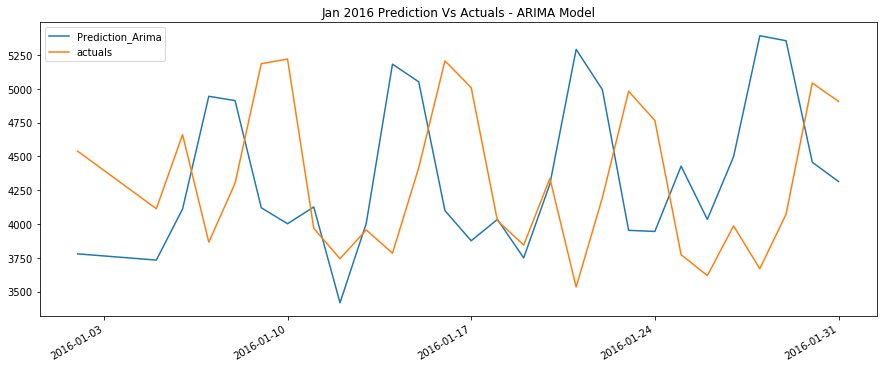

In [51]:
merged_arima.plot()
plt.title("Jan 2016 Prediction Vs Actuals - ARIMA Model")
plt.show()

#### Observation:
The daily data prediction has been closely following a trend with that of the actuals

### <a id="arima3">4. Auto ARIMA for Time Series</a>

In [52]:
#### Let us use Auto ARIMA to find out the predictions for sales data.
from pyramid.arima import auto_arima
stepwise_model = auto_arima(ts, start_p=1, start_q=1,
                           max_p=10, max_q=10, m=365,
                           start_P=0, max_P=10, seasonal=True,
                           d=0, D=0,
                           trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)
print(stepwise_model.aic())

Fit ARIMA: order=(1, 0, 1) seasonal_order=(0, 0, 1, 365); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(0, 0, 0) seasonal_order=(0, 0, 0, 365); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(1, 0, 0) seasonal_order=(1, 0, 0, 365); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(0, 0, 1) seasonal_order=(0, 0, 1, 365); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(0, 0, 1) seasonal_order=(1, 0, 1, 365); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(0, 0, 1) seasonal_order=(1, 0, 0, 365); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(0, 0, 1) seasonal_order=(2, 0, 1, 365); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(1, 0, 1) seasonal_order=(2, 0, 1, 365); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(1, 0, 0) seasonal_order=(2, 0, 1, 365); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(2, 0, 1) seasonal_order=(2, 0, 1, 365); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(2, 0, 1) sea

In [53]:
stepwise_model.aic()

16601.362931948086

In [54]:
stepwise_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                 1089
Model:               SARIMAX(3, 0, 5)   Log Likelihood               -8290.681
Date:                Sun, 12 Aug 2018   AIC                          16601.363
Time:                        11:06:03   BIC                          16651.293
Sample:                             0   HQIC                         16620.261
                               - 1089                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   1254.5452    515.049      2.436      0.015     245.069    2264.022
ar.L1          0.4436      0.049      8.978      0.000       0.347       0.540
ar.L2         -0.6061      0.023    -26.811      0.000      -0.650      -0.562
ar.L3          0.8728      0.048     18.003      0.000       0.778       0.968
ma.L1          0.3121      0.062      4.995      0.000       0.190       0.435
ma.L2          0.7368      0.081      9.105      0.000       0.578       0.895
ma.L3         -0.3939      0.113     -3.481      0.000      -0.616      -0.172
ma.L4         -0.2282      0.073     -3.147      0.002      -0.370      -0.086
ma.L5         -0.2814      0.054     -5.221      0.000      -0.387      -0.176
sigma2      3.066e+05   1.49e+04     20.630      0.000    2.77e+05    3.36e+05
===================================================================================
Ljung-Box (Q):                     1707.31   Jarque-Bera (JB):                80.11
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.14   Skew:                             0.16
Prob(H) (two-sided):                  0.21   Kurtosis:                         4.29
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [55]:
# Provide the train data as ts_log and fit the model using train Dataset.
train  = ts_log
fit_model = stepwise_model.fit(train)

In [56]:
# Use the model predict function for next 31 days and convert the log values to normal values using np.exp
predict_autoarima = np.exp(fit_model.predict(31))
predict_autoarima = predict_autoarima.astype(int)

In [57]:
future_forecast_autoarima = pd.DataFrame(predict_autoarima,index = index,columns=['Prediction_autoarima'])
future_forecast_autoarima.head(5)

,Prediction_autoarima
2016-01-01,5165
2016-01-02,4974
2016-01-03,4856
2016-01-04,4678
2016-01-05,4766


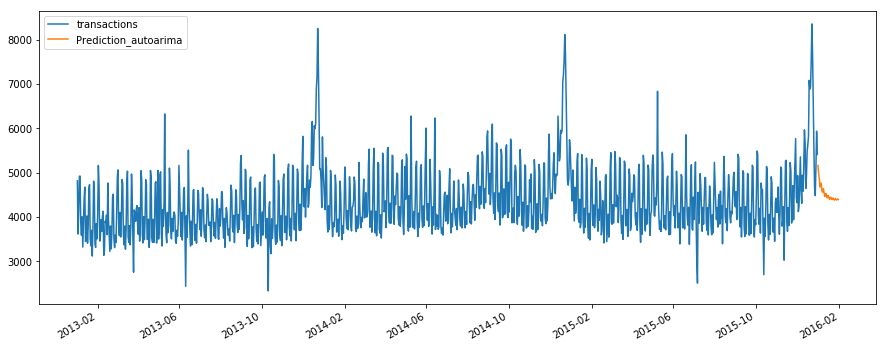

In [58]:
pd.concat([np.exp(train),future_forecast_autoarima],axis=1).plot()
plt.show()

#### Observation:
We can observe that the plot follows the trend that is as similar to that of earlier years of sales graph.

In [59]:
sum(future_forecast_autoarima['Prediction_autoarima'])

140575

In [60]:
merged_autoarima = future_forecast_autoarima.merge(jan_2016_data_pd, left_index=True, right_index=True, how='inner')
merged_autoarima = merged_autoarima.drop('date', axis = 1)
merged_autoarima.head()

,Prediction_autoarima,actuals
2016-01-02,4974,4539
2016-01-05,4766,4113
2016-01-06,4756,4661
2016-01-07,4576,3866
2016-01-08,4563,4301


In [61]:
print("Sum of Predicted sales from Auto ARIMA for Jan 2016 : " , sum(merged_autoarima['Prediction_autoarima']))
print("Sum of Actuals sales from Auto ARIMA for Jan 2016 : " , sum(merged_autoarima['actuals']))

('Sum of Predicted sales from Auto ARIMA for Jan 2016 : ', 125876)
('Sum of Actuals sales from Auto ARIMA for Jan 2016 : ', 120720)


In [62]:
rmse = sqrt(mean_squared_error(merged_arima['actuals'], merged_autoarima['Prediction_autoarima']))
print('The RMSE Value is : %f' % rmse)    

The RMSE Value is : 553.061996


In [65]:
mape =  mean_absolute_percentage_error(merged_arima['actuals'], merged_autoarima['Prediction_autoarima'])
print('The MAPE is : %f' % mape)    

The MAPE is : 71.428571


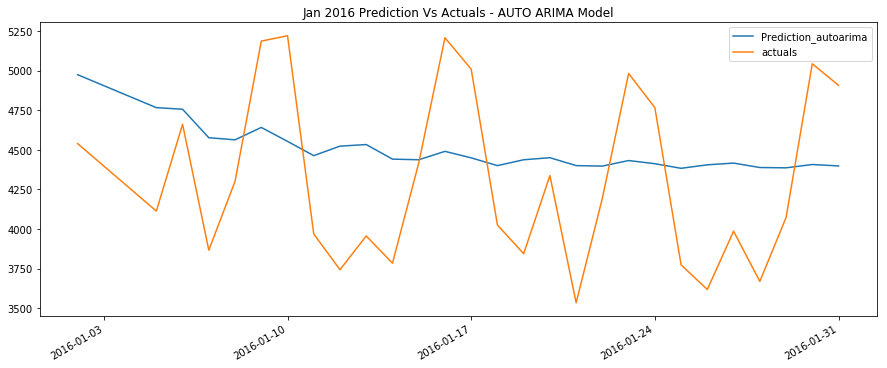

In [66]:
merged_autoarima.plot()
plt.title("Jan 2016 Prediction Vs Actuals - AUTO ARIMA Model")
plt.show()

#### Observation:
1. The RMSE value compared to the ARIMA model is better in AUTO ARIMA
2. But the plot has no variation, but has provided a smooth mean curve over a period of time.
3. The overal predicted sales for Jan 2016 has also be higher. Probably this may work if we extend the duration over a period of time

### <a id="sulekhaholt">5. Sulekha-Holtwinters implementation </a>

#### In this section we will use the Sulekha_Holtwinter library to predict the time series.

In [67]:
#import package from sulekha_holtwinters.holtwinters
import sulekha_holtwinters
from sulekha_holtwinters import holtwinters as hw
hd = hw.holtwinters()
import sys

In [68]:
ts_2 = ts.reset_index()

In [69]:
# Load the dataset
ts_2 = sqlContext.createDataFrame(ts_2)

In [70]:
ts_2.show()

+-------------------+------------+
|               date|transactions|
+-------------------+------------+
|1357084800000000000|      4821.0|
|1357171200000000000|      3618.0|
|1357257600000000000|      4169.0|
|1357344000000000000|      4921.0|
|1357430400000000000|      4925.0|
|1357516800000000000|      3871.0|
|1357603200000000000|      3593.0|
|1357689600000000000|      4006.0|
|1357776000000000000|      3323.0|
|1357862400000000000|      3873.0|
|1357948800000000000|      4423.0|
|1358035200000000000|      4676.0|
|1358121600000000000|      3450.0|
|1358208000000000000|      3527.0|
|1358294400000000000|      4026.0|
|1358380800000000000|      3412.0|
|1358467200000000000|      3801.0|
|1358553600000000000|      4656.0|
|1358640000000000000|      4732.0|
|1358726400000000000|      3508.0|
+-------------------+------------+
only showing top 20 rows



In [71]:
ts_2.count()

1089

In [72]:
# Applying Sulekha Holtwinters to find out observed, prediction values. 
Observed, Predictions, Level, Trend, Seasonality = hd.holtwinters_additive(ts_2,0.865,0.01,0.865,365,31)

In [73]:
print(" *** Model Metrics *** ")
print("Accuracy : ", hd.Accuracy(Observed, Predictions))
print("Absolute Error : ", hd.ABSError(Observed, Predictions))
print("Error : ", hd.Error(Observed, Predictions))
print("MAPE : ", hd.MAPE(Observed, Predictions))
print("RMSE : ", hd.RMSE(Observed, Predictions))

 *** Model Metrics *** 
('Accuracy : ', 99.81434094043071)
('Absolute Error : ', 8459.442590997267)
('Error : ', -334.8200979315325)
('MAPE : ', 0.18565905956920556)
('RMSE : ', 328.86136003245656)


#### Observation: 
The RMSE here is 328 which is the best of all other algorithms tried.

In [74]:
# We will see the which are the best parameters for the prediction so that we can verify we have used the right ones
hd.BestFit_Additive(ts_2, interval=865, denominator=1000,L = 365,n_predictions = 31)

(99.77768981288756, 0.865, 0.0, 0.865)

#### The right ones are used in the model.

In [76]:
SeasonalIndices,Avgs,Subset = hd.initiate_seasonal_indices_additive(ts_2,24)

In [77]:
model1 = hd.holtwinters_additive(ts_2,0.865,0.01,0.865,365,31)
hd.CreateGraphs(model1)

In [78]:
len(Predictions) - ts_2.count() 
predict_HW = pd.DataFrame(Predictions[ts_2.count():], columns = ['Predict HW'] )
predict_HW = predict_HW.astype(int)

In [79]:
predict_HW.index = future_forecast_arima.index
predict_HW.head()

,Predict HW
2016-01-01,5774
2016-01-02,5356
2016-01-03,5690
2016-01-04,5239
2016-01-05,5255


In [80]:
merged_HW = predict_HW.merge(jan_2016_data_pd, left_index=True, right_index=True, how='inner')
merged_HW = merged_HW.drop('date', axis = 1)
merged_HW.head()

,Predict HW,actuals
2016-01-02,5356,4539
2016-01-05,5255,4113
2016-01-06,4820,4661
2016-01-07,5481,3866
2016-01-08,5048,4301


In [81]:
print("Sum of Predicted sales for Jan 2016 : " , sum(merged_HW['Predict HW']))
print("Sum of Actuals sales for Jan 2016 : " , sum(merged_HW['actuals']))

('Sum of Predicted sales for Jan 2016 : ', 131601)
('Sum of Actuals sales for Jan 2016 : ', 120720)


In [86]:
rmse = sqrt(mean_squared_error(merged_HW['actuals'], merged_HW['Predict HW']))
print('The RMSE Value is : %f' % rmse)    

The RMSE Value is : 800.635484


In [85]:
mape =  mean_absolute_percentage_error(merged_HW['actuals'], merged_HW['Predict HW'])
print('The MAPE is : %f' % mape)    

The MAPE is : 71.428571


#### Observation:
The RMSE for the prediction duration is better than the ARIMA but greater than that of AUTO ARIMA.

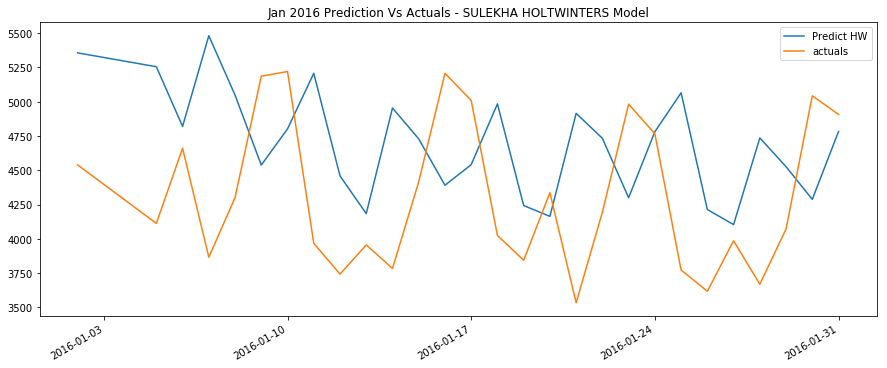

In [87]:
merged_HW.plot()
plt.title("Jan 2016 Prediction Vs Actuals - SULEKHA HOLTWINTERS Model")
plt.show()

### <a id="prophet"> 6. Prophet and Time Series </a>

In [88]:
ts_prophet = ts.reset_index()
ts_prophet = ts_prophet.rename(columns={'date':'ds', 'transactions':'y'})
ts_prophet['y'] = np.log(ts_prophet['y'])
ts_prophet.tail()

,ds,y
1084,2015-12-27,8.445912
1085,2015-12-28,8.408494
1086,2015-12-29,8.545392
1087,2015-12-30,8.689128
1088,2015-12-31,8.596743


In [89]:
model = Prophet()
model.fit(ts_prophet);

INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [90]:
future =  model.make_future_dataframe(periods=31, freq = 'd')
future.tail()

,ds
1115,2016-01-27
1116,2016-01-28
1117,2016-01-29
1118,2016-01-30
1119,2016-01-31


In [91]:
predict_prophet = model.predict(future)
predict_prophet.tail()

,ds,trend,trend_lower,trend_upper,yhat_lower,yhat_upper,seasonal,seasonal_lower,seasonal_upper,seasonalities,seasonalities_lower,seasonalities_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,yhat
1115,2016-01-27,8.383504,8.382596,8.384425,8.258016,8.457266,-0.028703,-0.028703,-0.028703,-0.028703,-0.028703,-0.028703,-0.000854,-0.000854,-0.000854,-0.027849,-0.027849,-0.027849,8.354801
1116,2016-01-28,8.383545,8.382512,8.384602,8.132476,8.344609,-0.140758,-0.140758,-0.140758,-0.140758,-0.140758,-0.140758,-0.116835,-0.116835,-0.116835,-0.023922,-0.023922,-0.023922,8.242788
1117,2016-01-29,8.383587,8.382417,8.384742,8.249017,8.451753,-0.030978,-0.030978,-0.030978,-0.030978,-0.030978,-0.030978,-0.010483,-0.010483,-0.010483,-0.020495,-0.020495,-0.020495,8.352609
1118,2016-01-30,8.383629,8.382380,8.384847,8.433911,8.637207,0.158143,0.158143,0.158143,0.158143,0.158143,0.158143,0.175821,0.175821,0.175821,-0.017678,-0.017678,-0.017678,8.541772
1119,2016-01-31,8.383670,8.382343,8.384986,8.413520,8.605176,0.125060,0.125060,0.125060,0.125060,0.125060,0.125060,0.140613,0.140613,0.140613,-0.015554,-0.015554,-0.015554,8.508730


In [92]:
rmse = sqrt(mean_squared_error(ts_prophet['y'], predict_prophet['yhat'][:len(predict_prophet)-31]))
print('The RMSE Value is : %f' % rmse)    

The RMSE Value is : 0.078399


In [94]:
mape =  mean_absolute_percentage_error(ts_prophet['y'], predict_prophet['yhat'][:len(predict_prophet)-31])
print('The MAPE is : %f' % mape)    

The MAPE is : 0.614286


In [95]:
predict_prophet = predict_prophet[['ds', 'yhat']]
predict_prophet.columns = ['date', 'Prediction_prophet']
predict_prophet.set_index('date')
predict_prophet['Prediction_prophet'] = np.exp(predict_prophet['Prediction_prophet'])
predict_prophet.head()

,date,Prediction_prophet
0,2013-01-02,4553.829146
1,2013-01-03,3965.644438
2,2013-01-04,4314.953831
3,2013-01-05,5089.334642
4,2013-01-06,4814.670772


In [96]:
predict_prophet.set_index('date', inplace = True)

In [97]:
predict_prophet = predict_prophet.astype(int)

In [98]:
merged_prophet = predict_prophet.merge(jan_2016_data_pd, left_index=True, right_index=True, how='inner')
merged_prophet = merged_prophet.drop('date', axis = 1)
merged_prophet.head()

,Prediction_prophet,actuals
date,,
2016-01-02,6123,4539
2016-01-05,4286,4113
2016-01-06,4700,4661
2016-01-07,4102,3866
2016-01-08,4477,4301


In [ ]:
print("Sum of Predicted sales for Jan 2016 : " , sum(merged_prophet['Prediction_prophet']))
print("Sum of Actuals sales for Jan 2016 : " , sum(merged_prophet['actuals']))

In [99]:
rmse = sqrt(mean_squared_error(merged_prophet['actuals'], merged_prophet['Prediction_prophet']))
print('The RMSE Value is : %f' % rmse) 

The RMSE Value is : 342.254239


In [100]:
mape =  mean_absolute_percentage_error(merged_prophet['actuals'], merged_prophet['Prediction_prophet'])
print('The MAPE is : %f' % mape)    

The MAPE is : 64.285714


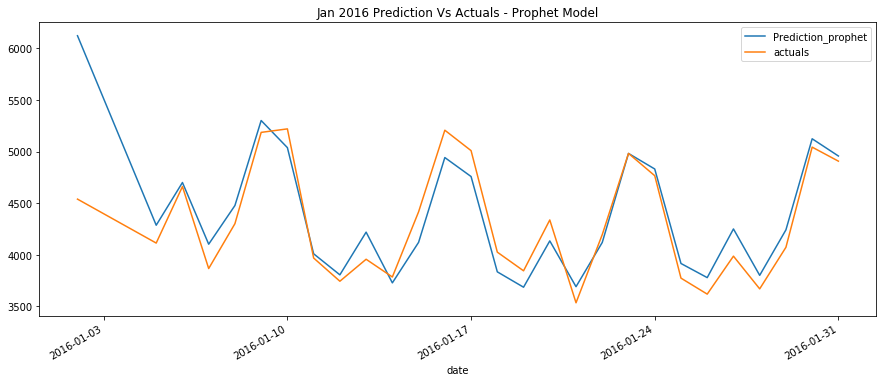

In [101]:
merged_prophet.plot()
plt.title("Jan 2016 Prediction Vs Actuals - Prophet Model")
plt.show()

#### Observation:
Prophet has the best prediction in terms of plot and also the RMSE is much lower compared to the other models.

### <a id="itempred"> 7. Prediction for Top 10 Items </a>

In [102]:
train_data.show(5)

+--------+-----+-------------------+---------+----------+-----------+------------+-----+----------+
|item_nbr|   id|               date|store_nbr|unit_sales|onpromotion|      family|class|perishable|
+--------+-----+-------------------+---------+----------+-----------+------------+-----+----------+
|  103520|32292|2013-01-02 00:00:00|       44|      12.0|       null|   GROCERY I| 1028|         0|
|  103665|32293|2013-01-02 00:00:00|       44|      20.0|       null|BREAD/BAKERY| 2712|         1|
|  105574|32294|2013-01-02 00:00:00|       44|      51.0|       null|   GROCERY I| 1045|         0|
|  105575|32295|2013-01-02 00:00:00|       44|      74.0|       null|   GROCERY I| 1045|         0|
|  105577|32296|2013-01-02 00:00:00|       44|      23.0|       null|   GROCERY I| 1045|         0|
+--------+-----+-------------------+---------+----------+-----------+------------+-----+----------+
only showing top 5 rows



In [103]:
item_group = train_data.groupBy(col("item_nbr"), col("family")).sum('unit_sales').orderBy(col('sum(unit_sales)'), ascending = False).limit(10)
item_group.show()

+--------+---------+------------------+
|item_nbr|   family|   sum(unit_sales)|
+--------+---------+------------------+
| 1047679|BEVERAGES|          558899.0|
| 1503844|  PRODUCE|327472.36369999975|
| 1473474|  PRODUCE| 238201.8105999999|
|  819932|BEVERAGES|          175411.0|
| 1047690|BEVERAGES|          167335.0|
| 1037857|BEVERAGES|          164097.0|
| 1430040|BEVERAGES|          143220.0|
|  364606|GROCERY I|          132350.0|
|  464374|BEVERAGES|          125925.0|
| 1074327|BEVERAGES|          125430.0|
+--------+---------+------------------+



#### Observation:
Items of Beverages are mostly selling in terms of Unit Sales. Let us predict the sales for each of the items for Jan 2016 using Prophet since it has the least overall RMSE and also better fit.

In [104]:
# Let us first create a dictionary of 10 items to do the iterative process
item_list = item_group.select('item_nbr')
item_list = item_list.toPandas()
item_list = item_list['item_nbr'].values.tolist()
item_df = {}
i = 0
for item in item_list:
    item_df[i] = str(item) 
    i = i + 1

In [105]:
# Create a dictionary having key values pairs of item number and the corresponding unit sales data.
item_df_dict = {}
for k, v in item_df.items():   
     df_data = train_data.groupBy(col('item_nbr'),col("date")).sum('unit_sales')
     df_data = df_data.filter(col("item_nbr") == v).orderBy(col('date')).toPandas()
     item_df_dict[v] = df_data

In [106]:
#Load the full train data having store 44 and Jan 2016 data
full_train_data = sqlContext.read.csv("/gl-capstone-data/Team6-C-Sep/Data/train_item_44_jan2016.csv",header = True,inferSchema = True)

In [107]:
full_train_data_pd = full_train_data.toPandas()
full_train_data_pd.head()

,date,item_nbr,unit_sales
0,2016-01-02,103520,8.0
1,2016-01-02,103665,11.0
2,2016-01-02,105574,22.0
3,2016-01-02,105575,47.0
4,2016-01-02,105577,1.0


In [108]:
# This function will do the prediction using Prophet and plot the Prediction Vs Actuals
def prophetise(key, value):
    ts_prophet = value.rename(columns={'date':'ds', 'sum(unit_sales)':'y'})
    ts_prophet['y'] = np.log(ts_prophet['y'])
    # Predict the model for each item data
    model = Prophet()
    model.fit(ts_prophet); 
    future =  model.make_future_dataframe(periods=31, freq = 'd')
    
    # Process the dataset formed out of prediction
    item_prophet_df = model.predict(future)
    item_prophet_df = item_prophet_df[['ds', 'yhat']]
    item_prophet_df.columns = ['date', 'Prediction_prophet']
    item_prophet_df['Prediction_prophet'] = np.exp(item_prophet_df['Prediction_prophet']).astype(int)
    item_prophet_df.set_index('date', inplace = True)

    # Merge the datast with that of original prediction
    full_train_item_pd = full_train_data_pd[full_train_data_pd['item_nbr'] == int(key)]
    full_train_item_pd.set_index('date', inplace = True)
    full_train_item_pd.drop("item_nbr", axis = 1 , inplace = True)
    merged_prophet_df = item_prophet_df.merge(full_train_item_pd, left_index=True, right_index=True, how='inner')
    merged_prophet_df.columns = ['Prediction_prophet', 'actuals']
 
    
    #Plot the prediction
    merged_prophet_df.plot()
    plt.title("Jan 2016 Prediction Vs Actuals - Prophet Model - Item #" + str(key))
    return merged_prophet_df

INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=Tr

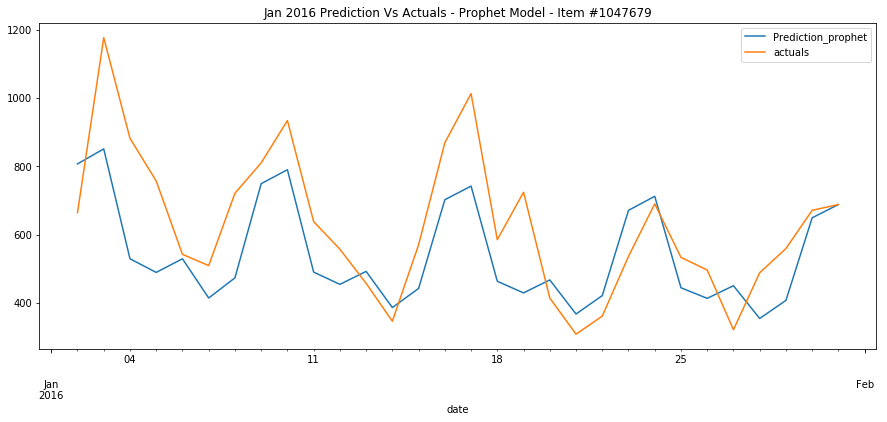

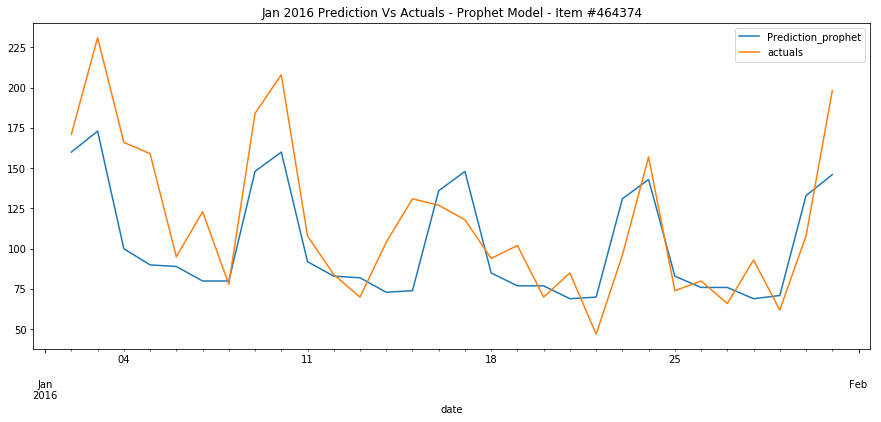

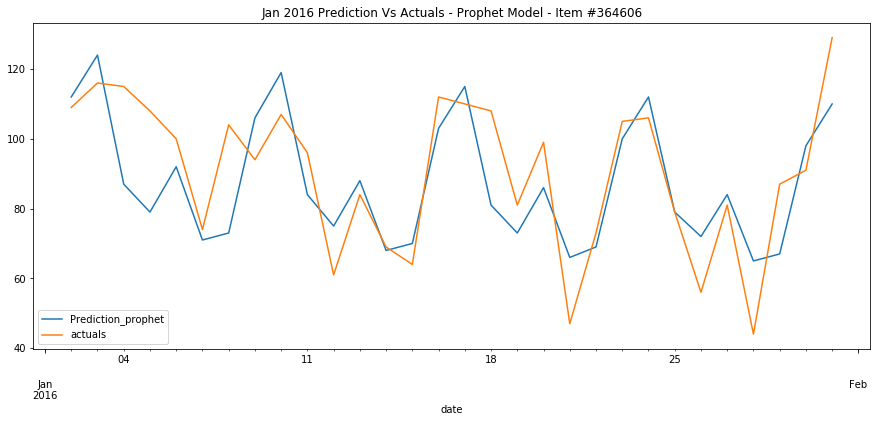

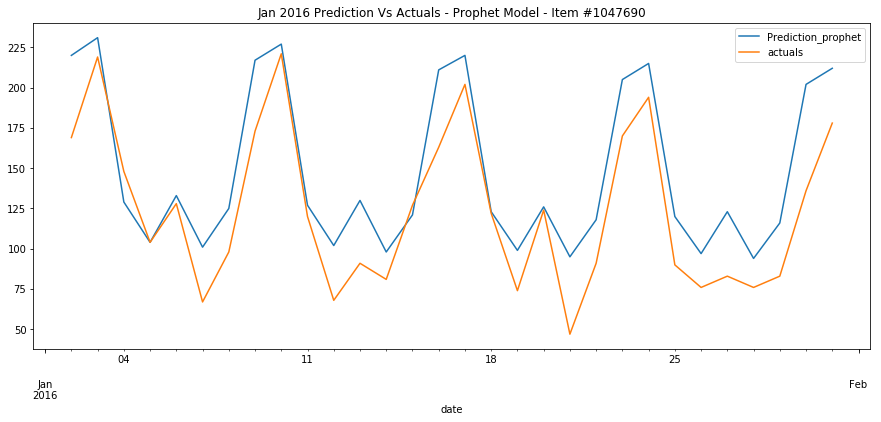

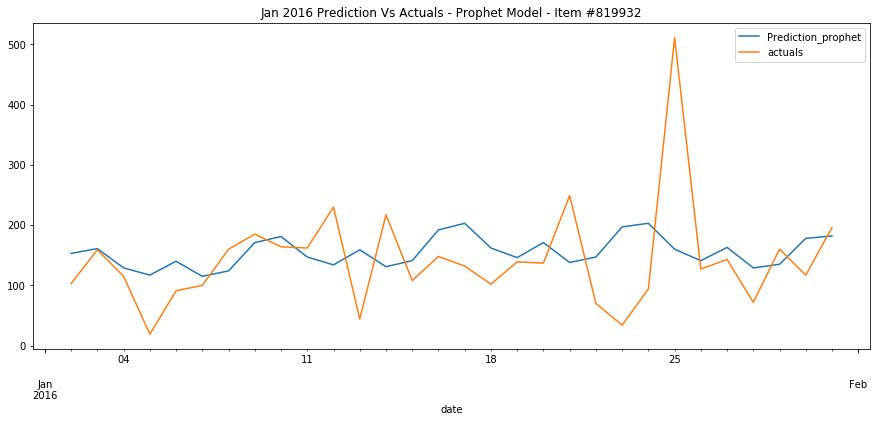

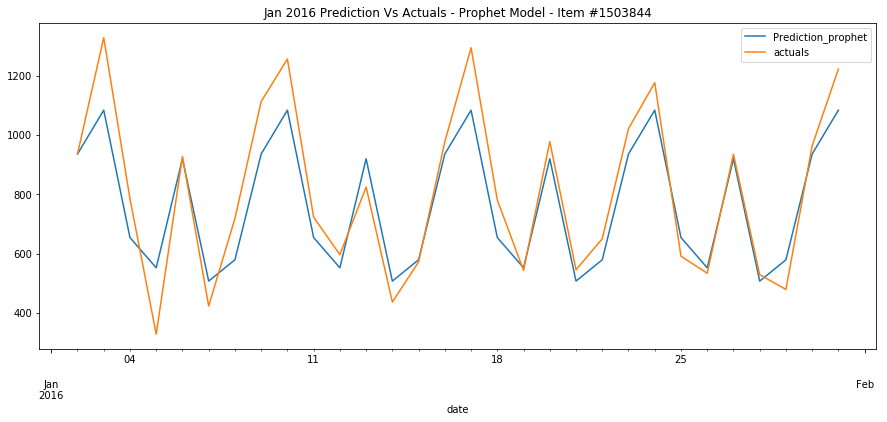

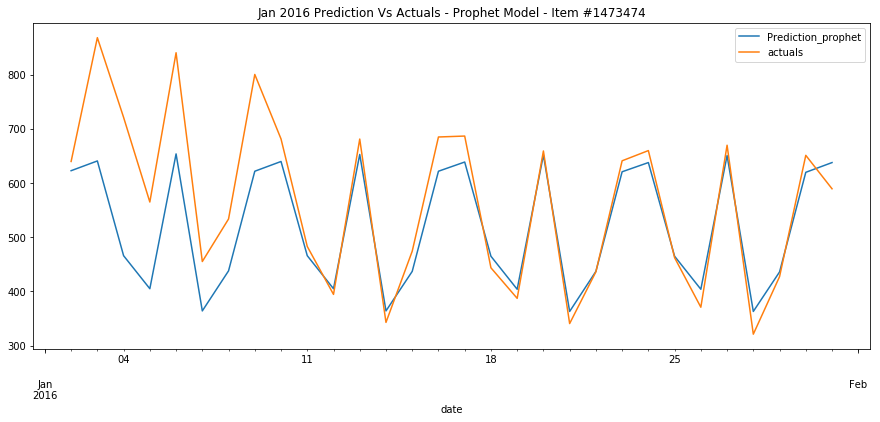

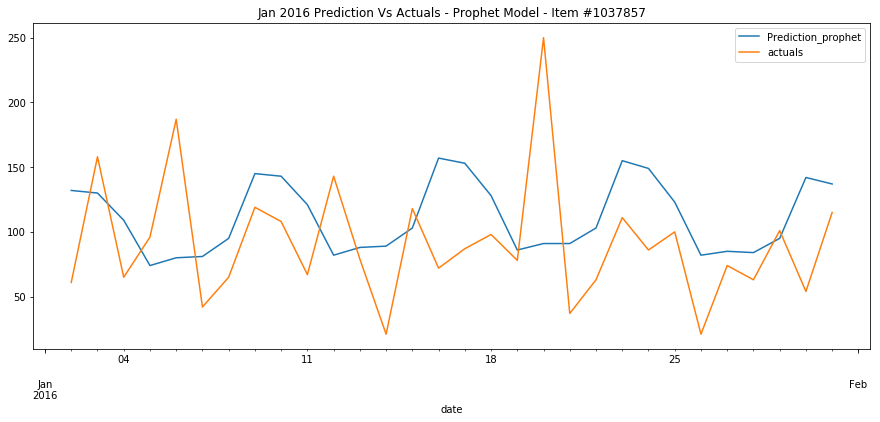

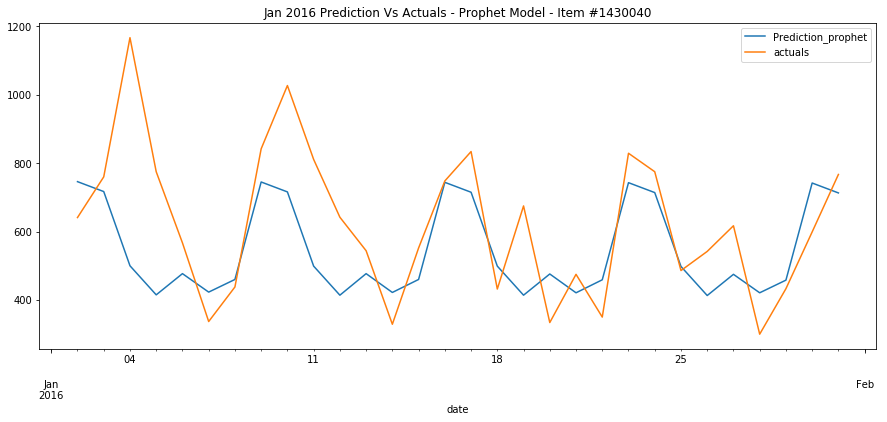

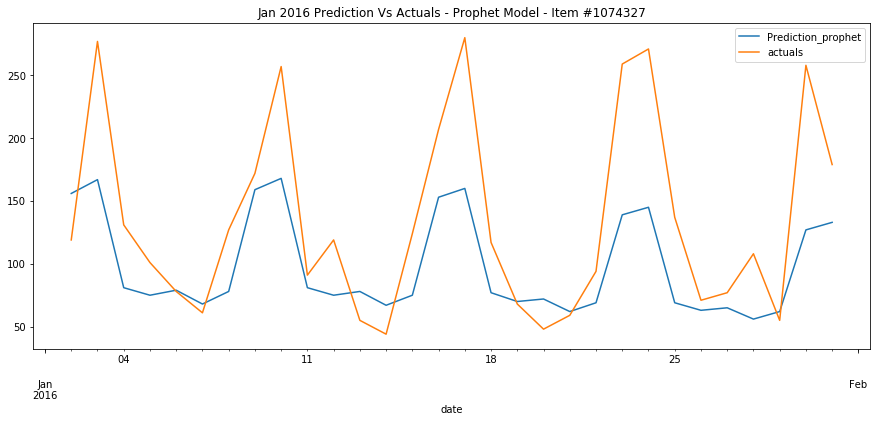

In [109]:
prophet_dict = {}
for k, v  in item_df_dict.iteritems():
    prophet_dict[k] = prophetise(k, v)

### Observation:
    1. The prediction for individual items for the month of Jan 2016 has been almost similar to that of the actuals. Hence the prophet model is performing well with the predictions.